# 1.1 Preprocessing and Dataset Analysis

All the package imports.

In [22]:
from datasets import load_dataset
import pandas as pd
import re
import spacy
from spacy.lang.fi import Finnish
from spacy.lang.en import English
from spacy.lang.ja import Japanese
from spacy.tokenizer import Tokenizer
from spacy.util import compile_prefix_regex, compile_infix_regex, compile_suffix_regex

import stanza

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

from enum import Enum

In [23]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Pipelines


Spacy pipelines

In [3]:
%%capture
!python -m spacy download en_core_web_sm
!python -m spacy download fi_core_news_sm
!python -m spacy download ja_core_news_sm

Stanza pipelines

In [4]:
%%capture
stanza.download('en')
stanza.download('fi')
stanza.download('ja')

2022-09-20 21:59:14 INFO: Downloading default packages for language: en (English) ...
2022-09-20 21:59:15 INFO: File exists: C:\Users\rasmu\stanza_resources\en\default.zip
2022-09-20 21:59:18 INFO: Finished downloading models and saved to C:\Users\rasmu\stanza_resources.
2022-09-20 21:59:19 INFO: Downloading default packages for language: fi (Finnish) ...
2022-09-20 21:59:20 INFO: File exists: C:\Users\rasmu\stanza_resources\fi\default.zip
2022-09-20 21:59:22 INFO: Finished downloading models and saved to C:\Users\rasmu\stanza_resources.
2022-09-20 21:59:23 INFO: Downloading default packages for language: ja (Japanese) ...
2022-09-20 21:59:24 INFO: File exists: C:\Users\rasmu\stanza_resources\ja\default.zip
2022-09-20 21:59:27 INFO: Finished downloading models and saved to C:\Users\rasmu\stanza_resources.


## Q1.1

Here we define some globals which will be used in Q1.1.

First, lets define the path where the preprocessed data will be stored for later use.
We could get issues if storing the data as CSV after tokenization, since the list of tokens:
"['a'], ['b']", will automatically be converted to a string (since the list contains ',').
So let's store it in pickle format.

In [5]:
path_train_set = "data/train_set_stanza.pkl"
path_validation_set = "data/validation_set_stanza.pkl"

The Annotation column can have one of this value on error (or the range on success).

In [6]:
class Annotation_error(Enum):
    UNANSWERED = -1
    BAD_TOKENIZATION_OR_DATA = -2
    IGNORED = -3

## Q1.1a

Let's download the dataset from the web.

In [7]:
%%capture
dataset_raw = load_dataset("copenlu/answerable_tydiqa")

In [8]:
train_set_raw = dataset_raw["train"].to_pandas()
validation_set_raw = dataset_raw["validation"].to_pandas()

In [9]:
train_set_raw.head()

,question_text,document_title,language,annotations,document_plaintext,document_url
0,Milloin Charles Fort syntyi?,Charles Fort,finnish,"{'answer_start': [18], 'answer_text': ['6. elo...",Charles Hoy Fort (6. elokuuta (joidenkin lähte...,https://fi.wikipedia.org/wiki/Charles%20Fort
1,“ダン” ダニエル・ジャドソン・キャラハンの出身はどこ,ダニエル・J・キャラハン,japanese,"{'answer_start': [35], 'answer_text': ['カリフォルニ...",“ダン”こと、ダニエル・ジャドソン・キャラハンは1890年7月26日、カリフォルニア州サンフ...,https://ja.wikipedia.org/wiki/%E3%83%80%E3%83%...
2,వేప చెట్టు యొక్క శాస్త్రీయ నామం ఏమిటి?,వేప,telugu,"{'answer_start': [12], 'answer_text': ['Azadir...","వేప (లాటిన్ Azadirachta indica, syn. Melia aza...",https://te.wikipedia.org/wiki/%E0%B0%B5%E0%B1%...
3,চেঙ্গিস খান কোন বংশের রাজা ছিলেন ?,চেঙ্গিজ খান,bengali,"{'answer_start': [414], 'answer_text': ['বোরজি...",চেঙ্গিজ খান (মঙ্গোলীয়: Чингис Хаан আ-ধ্ব-ব: ...,https://bn.wikipedia.org/wiki/%E0%A6%9A%E0%A7%...
4,రెయ్యలగడ్ద గ్రామ విస్తీర్ణత ఎంత?,రెయ్యలగడ్ద,telugu,"{'answer_start': [259], 'answer_text': ['27 హె...","రెయ్యలగడ్ద, విశాఖపట్నం జిల్లా, గంగరాజు మాడుగుల...",https://te.wikipedia.org/wiki/%E0%B0%B0%E0%B1%...


In [10]:
def print_preprocessing_summary(df):
    num_unanswered = df[df['document_answer_region'] == Annotation_error.UNANSWERED].shape[0]
    num_answered_but_failed = df[df['document_answer_region'] == Annotation_error.BAD_TOKENIZATION_OR_DATA].shape[0]
    num_answered = df.shape[0] - num_answered_but_failed - num_unanswered

    print("[Parsing Info] {} answered questions. {} unanswered questions. Failed to parse {} (answered) questions.".format(num_answered, num_unanswered, num_answered_but_failed))

### Preprocessing with Spacy

Let's do some preprocessing!

In [11]:
def spacy_custom_tokenizer(nlp):
    infixes = nlp.Defaults.infixes + [r"[\.\,]?\[\S*"]
    infix_re = spacy.util.compile_infix_regex(infixes)
    prefix_re = compile_prefix_regex(nlp.Defaults.prefixes)
    suffix_re = compile_suffix_regex(nlp.Defaults.suffixes)

    return Tokenizer(
        nlp.vocab,
        prefix_search=prefix_re.search,
        suffix_search=suffix_re.search,
        infix_finditer=infix_re.finditer,
        #token_match=nlp.tokenizer.token_match,
        rules=nlp.Defaults.tokenizer_exceptions)

In [12]:
def spacy_custom_nlp(pipeline_name: str):
    nlp = spacy.load(pipeline_name)
    nlp.tokenizer = spacy_custom_tokenizer(nlp)
    return nlp

In [13]:
def preprocess_annotation(raw_sample, nlp):
    document_doc = nlp(raw_sample['document_plaintext'])
    annotations = raw_sample['annotations']

    # extract answer annotations
    start = annotations['answer_start'][0]
    if start == -1: # unanswered question
        region = Annotation_error.UNANSWERED
    else:
        length = len(annotations['answer_text'][0])
        end = start + length

        span = document_doc.char_span(start, end) # or None if the span is within a token

        if span == None: # the answer region does not match token boundaries (either due to poor tokenzation or poor data labelling)
            region = Annotation_error.BAD_TOKENIZATION_OR_DATA
        else:
            region = (span.start, span.end)

    return region

def preprocess_language(raw_df, nlp, preprocess_annotations: bool = False, num_max_rows=-1):
    rows = len(raw_df)
    
    if num_max_rows > 0: # @Remove
        rows = min(rows, num_max_rows)
    
    columns = ['language', 'question', 'document_title', 'document', 'document_answer_region']
    df = pd.DataFrame(columns=columns, index=range(rows))
    
    df['language'] = raw_df['language'].iloc[0]
 
    for i in range(rows):
        raw_sample = raw_df.iloc[i]

        df.at[i,'question'] = [t.text for t in nlp(raw_sample['question_text'])]
        df.at[i,'document_title'] = [t.text for t in nlp(raw_sample['document_title'])]
        df.at[i,'document'] = [t.text for t in nlp(raw_sample['document_plaintext'])]
        
        
        if preprocess_annotations:
            answer_region = preprocess_annotation(raw_sample, nlp)
        else:
            answer_region = Annotation_error.IGNORED    
        
        df.at[i,'document_answer_region'] = answer_region
        
        
        if i % 1000  == 0:
            print("sample {}/{}".format(i, rows))
            
        if i == num_max_rows: # @Remove
            break
    
    return df

In [14]:
def preprocess(raw_data, max_rows_per_language=-1):
    # @Note: how pipelines work in spacy: https://spacy.io/usage/processing-pipelines
    
    # english
    raw_data_en = raw_data[raw_data['language'] == 'english']
    nlp_en = spacy_custom_nlp('en_core_web_sm')
    data_en = preprocess_language(raw_data_en, nlp_en, num_max_rows=max_rows_per_language)
    print_preprocessing_summary(data_en)
    
    # finnish
    raw_data_fi = raw_data[raw_data['language'] == 'finnish']
    nlp_fi = spacy_custom_nlp('fi_core_news_sm')
    data_fi = preprocess_language(raw_data_fi, nlp_fi, num_max_rows=max_rows_per_language)
    print_preprocessing_summary(data_fi)
    
    # japanese
    # @Note: for some reason, the pretrained pipeline doesn't work well with finding the answer. Japenese() works a lot better. However, maybe it just tokenizes each symbol
    raw_data_ja = raw_data[raw_data['language'] == 'japanese']
    nlp_ja = spacy_custom_nlp('ja_core_news_sm')
    data_ja = preprocess_language(raw_data_ja, nlp_ja, num_max_rows=max_rows_per_language) 
    print_preprocessing_summary(data_ja)
    
    # concat
    data = pd.concat([data_en, data_fi, data_ja])
    
    return data


### Preprocessing with Staza

In [24]:
def preprocess_annotation(raw_sample, nlp):
    doc = nlp(raw_sample['document_plaintext'])
    annotations = raw_sample['annotations']

    # extract answer annotations
    start = annotations['answer_start'][0]
    if start == -1: # unanswered question
        region = Annotation_error.UNANSWERED
    else:
        length = len(annotations['answer_text'][0])
        end = start + length
        
        ids = np.array([token.id for sentence in doc.sentences for token in sentence.tokens])
        start_chars = np.array([token.start_char for sentence in doc.sentences for token in sentence.tokens])
        end_chars = np.array([token.end_char for sentence in doc.sentences for token in sentence.tokens])
        
        start_index = ids[start_chars == start]
        end_index = ids[end_chars == end]
        
        if start_index.shape[0] == 0 or end_index.shape[0] == 0: # the answer region does not match token boundaries (either due to poor tokenzation or poor data labelling)
            region = Annotation_error.BAD_TOKENIZATION_OR_DATA
        else:
            assert(start_index.shape[0] == 1)
            assert(end_index.shape[0] == 1)
            
            region = (start_index[0][0], end_index[0][0])

    return region

def extract_tokens(doc):
    return [token.text for sentence in doc.sentences for token in sentence.tokens]

def preprocess_language(raw_df, nlp, preprocess_annotations: bool = True, num_max_rows=-1):
    rows = len(raw_df)
    
    if num_max_rows > 0: # early terminate for testing
        rows = min(rows, num_max_rows)
    
    columns = ['language', 'question', 'document_title', 'document', 'document_answer_region']
    df = pd.DataFrame(columns=columns, index=range(rows))
    
    df['language'] = raw_df['language'].iloc[0]
 
    for i in range(rows):
        raw_sample = raw_df.iloc[i]

        df.at[i,'question'] = extract_tokens(nlp(raw_sample['question_text']))
        df.at[i,'document_title'] = extract_tokens(nlp(raw_sample['document_title']))
        df.at[i,'document'] = extract_tokens(nlp(raw_sample['document_plaintext']))
        
        if preprocess_annotations:
            answer_region = preprocess_annotation(raw_sample, nlp)
        else:
            answer_region = Annotation_error.IGNORED    
        
        df.at[i,'document_answer_region'] = answer_region
        
        
        if i % 1000  == 0:
            print("sample {}/{}".format(i, rows))
            
        if i == num_max_rows:
            print("early terminating...")
            break
    
    return df

In [25]:
def preprocess(raw_data, max_rows_per_language=-1):
    # english
    raw_data_en = raw_data[raw_data['language'] == 'english']
    nlp_en = stanza.Pipeline(lang='en', processors='tokenize')
    data_en = preprocess_language(raw_data_en, nlp_en, num_max_rows=max_rows_per_language)
    print_preprocessing_summary(data_en)
    
    # finnish
    raw_data_fi = raw_data[raw_data['language'] == 'finnish']
    nlp_fi = stanza.Pipeline(lang='fi', processors='tokenize')
    data_fi = preprocess_language(raw_data_fi, nlp_fi, num_max_rows=max_rows_per_language)
    print_preprocessing_summary(data_fi)
    
    # japanese
    raw_data_ja = raw_data[raw_data['language'] == 'japanese']
    nlp_ja = stanza.Pipeline(lang='ja', processors='tokenize')
    data_ja = preprocess_language(raw_data_ja, nlp_ja, num_max_rows=max_rows_per_language) 
    print_preprocessing_summary(data_ja)
    
    # concat
    data = pd.concat([data_en, data_fi, data_ja])
    
    return data


Let's preprocess the training data

In [17]:
train_set = preprocess(train_set_raw, max_rows_per_language = -1)

2022-09-20 21:59:37 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2022-09-20 21:59:38 INFO: Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |

2022-09-20 21:59:38 INFO: Use device: cpu
2022-09-20 21:59:38 INFO: Loading: tokenize
2022-09-20 21:59:38 INFO: Done loading processors!


sample 0/7389
sample 1000/7389
sample 2000/7389
sample 3000/7389
sample 4000/7389
sample 5000/7389
sample 6000/7389
sample 7000/7389


2022-09-20 22:55:05 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


[Parsing Info] 3601 answered questions. 3693 unanswered questions. Failed to parse 95 (answered) questions.


2022-09-20 22:55:06 WARNING: Language fi package default expects mwt, which has been added
2022-09-20 22:55:06 INFO: Loading these models for language: fi (Finnish):
| Processor | Package |
-----------------------
| tokenize  | tdt     |
| mwt       | tdt     |

2022-09-20 22:55:06 INFO: Use device: cpu
2022-09-20 22:55:06 INFO: Loading: tokenize
2022-09-20 22:55:06 INFO: Loading: mwt
2022-09-20 22:55:06 INFO: Done loading processors!


sample 0/13701


C:\Users\rasmu\AppData\Local\Temp\ipykernel_11972\4181339218.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ids = np.array([token.id for sentence in doc.sentences for token in sentence.tokens])


sample 1000/13701
sample 2000/13701
sample 3000/13701
sample 4000/13701
sample 5000/13701
sample 6000/13701
sample 7000/13701
sample 8000/13701
sample 9000/13701
sample 10000/13701
sample 11000/13701
sample 12000/13701
sample 13000/13701
[Parsing Info] 6350 answered questions. 6846 unanswered questions. Failed to parse 505 (answered) questions.


2022-09-21 01:39:36 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2022-09-21 01:39:39 INFO: Loading these models for language: ja (Japanese):
| Processor | Package |
-----------------------
| tokenize  | gsd     |

2022-09-21 01:39:39 INFO: Use device: cpu
2022-09-21 01:39:39 INFO: Loading: tokenize
2022-09-21 01:39:39 INFO: Done loading processors!


sample 0/8778
sample 1000/8778
sample 2000/8778
sample 3000/8778
sample 4000/8778
sample 5000/8778
sample 6000/8778
sample 7000/8778
sample 8000/8778
[Parsing Info] 4202 answered questions. 4389 unanswered questions. Failed to parse 187 (answered) questions.


In [18]:
train_set.head()

,language,question,document_title,document,document_answer_region
0,english,"[When, was, quantum, field, theory, developed, ?]","[Quantum, field, theory]","[Quantum, field, theory, naturally, began, wit...","(26, 26)"
1,english,"[Who, was, the, first, Nobel, prize, winner, f...","[List, of, Nobel, laureates, in, Literature]","[The, Nobel, Prize, in, Literature, (, Swedish...","(12, 13)"
2,english,"[When, is, the, dialectical, method, used, ?]",[Dialectic],"[Dialectic, or, dialectics, (, Greek, :, διαλε...","(27, 49)"
3,english,"[Who, invented, Hangul, ?]","[Origin, of, Hangul]","[Hangul, was, personally, created, and, promul...","(16, 18)"
4,english,"[What, do, Grasshoppers, eat, ?]",[Grasshopper],"[Grasshoppers, are, plant, -, eaters, ,, with,...","(1, 37)"


Let's preprocess the validation data

In [27]:
validation_set = preprocess(validation_set_raw, max_rows_per_language=-1)

2022-09-21 10:28:05 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2022-09-21 10:28:19 INFO: Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |

2022-09-21 10:28:19 INFO: Use device: cpu
2022-09-21 10:28:19 INFO: Loading: tokenize
2022-09-21 10:28:19 INFO: Done loading processors!


sample 0/990


2022-09-21 10:46:18 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


[Parsing Info] 486 answered questions. 495 unanswered questions. Failed to parse 9 (answered) questions.


2022-09-21 10:46:20 WARNING: Language fi package default expects mwt, which has been added
2022-09-21 10:46:20 INFO: Loading these models for language: fi (Finnish):
| Processor | Package |
-----------------------
| tokenize  | tdt     |
| mwt       | tdt     |

2022-09-21 10:46:20 INFO: Use device: cpu
2022-09-21 10:46:20 INFO: Loading: tokenize
2022-09-21 10:46:20 INFO: Loading: mwt
2022-09-21 10:46:20 INFO: Done loading processors!


sample 0/1686


C:\Users\rasmu\AppData\Local\Temp\ipykernel_11972\4181339218.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ids = np.array([token.id for sentence in doc.sentences for token in sentence.tokens])


sample 1000/1686


2022-09-21 11:07:53 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


[Parsing Info] 766 answered questions. 843 unanswered questions. Failed to parse 77 (answered) questions.


2022-09-21 11:07:55 INFO: Loading these models for language: ja (Japanese):
| Processor | Package |
-----------------------
| tokenize  | gsd     |

2022-09-21 11:07:55 INFO: Use device: cpu
2022-09-21 11:07:55 INFO: Loading: tokenize
2022-09-21 11:07:55 INFO: Done loading processors!


sample 0/1036
sample 1000/1036
[Parsing Info] 506 answered questions. 518 unanswered questions. Failed to parse 12 (answered) questions.


In [28]:
validation_set.head()

,language,question,document_title,document,document_answer_region
0,english,"[What, is, a, way, to, increase, your, wound, ...","[Wound, healing]","[Wound, care, encourages, and, speeds, wound, ...","(9, 15)"
1,english,"[Who, founded, the, Burntisland, Shipbuilding,...","[Burntisland, Shipbuilding, Company]","[Brothers, Amos, and, Wilfrid, Ayre, founded, ...","(1, 5)"
2,english,"[What, is, the, surface, area, of, the, human,...","[Cerebral, cortex]","[For, species, of, mammals, ,, larger, brains,...","(35, 38)"
3,english,"[When, did, the, case, of, R, (, Factortame, L...","[R, (, Factortame, Ltd, ), v, Secretary, of, S...","[As, from, 31, March, 1989, ,, fishing, vessel...","(37, 38)"
4,english,"[When, was, Quezon, City, founded, ?]","[Quezon, City]","[When, Quezon, City, was, created, in, 1939, ,...","(7, 7)"


## Paths

In [49]:
path_train_set = "data/train_set_stanza.pkl"
path_validation_set = "data/validation_set_stanza.pkl"

### Save pre-processed training and validation data

In [50]:
train_set.to_pickle(path_train_set)

In [51]:
validation_set.to_pickle(path_validation_set)

### Load pre-processed training and validation data

In [52]:
train_set = pd.read_pickle(path_train_set)
validation_set = pd.read_pickle(path_validation_set)

In [53]:
train_set.head()

,language,question,document_title,document,document_answer_region
0,english,"[When, was, quantum, field, theory, developed, ?]","[Quantum, field, theory]","[Quantum, field, theory, naturally, began, wit...","(26, 26)"
1,english,"[Who, was, the, first, Nobel, prize, winner, f...","[List, of, Nobel, laureates, in, Literature]","[The, Nobel, Prize, in, Literature, (, Swedish...","(12, 13)"
2,english,"[When, is, the, dialectical, method, used, ?]",[Dialectic],"[Dialectic, or, dialectics, (, Greek, :, διαλε...","(27, 49)"
3,english,"[Who, invented, Hangul, ?]","[Origin, of, Hangul]","[Hangul, was, personally, created, and, promul...","(16, 18)"
4,english,"[What, do, Grasshoppers, eat, ?]",[Grasshopper],"[Grasshoppers, are, plant, -, eaters, ,, with,...","(1, 37)"


In [54]:
validation_set.head()

,language,question,document_title,document,document_answer_region
0,english,"[What, is, a, way, to, increase, your, wound, ...","[Wound, healing]","[Wound, care, encourages, and, speeds, wound, ...","(9, 15)"
1,english,"[Who, founded, the, Burntisland, Shipbuilding,...","[Burntisland, Shipbuilding, Company]","[Brothers, Amos, and, Wilfrid, Ayre, founded, ...","(1, 5)"
2,english,"[What, is, the, surface, area, of, the, human,...","[Cerebral, cortex]","[For, species, of, mammals, ,, larger, brains,...","(35, 38)"
3,english,"[When, did, the, case, of, R, (, Factortame, L...","[R, (, Factortame, Ltd, ), v, Secretary, of, S...","[As, from, 31, March, 1989, ,, fishing, vessel...","(37, 38)"
4,english,"[When, was, Quezon, City, founded, ?]","[Quezon, City]","[When, Quezon, City, was, created, in, 1939, ,...","(7, 7)"


Just to make it easier to reference the training data onwards.

In [55]:
train_en = train_set[train_set["language"] == "english"]
train_fi = train_set[train_set["language"] == "finnish"]
train_ja = train_set[train_set["language"] == "japanese"]

In [56]:
validation_en = validation_set[validation_set["language"] == "english"]
validation_fi = validation_set[validation_set["language"] == "finnish"]
validation_ja = validation_set[validation_set["language"] == "japanese"]

## Q1.1b

Let's plot the most common start and end words of each question.

In [37]:
def plot_most_common_words(words, title, top=-1, font_prop=None, rotation=45):
    # @TODO: add subtitle/translation for x-axis (zip)
    uniques, uniques_counts = np.unique(words, return_counts=True)
    index_sorted = np.argsort(uniques_counts, axis=None)[::-1]
    
    if top > 0:
        index_sorted = index_sorted[:top]
    
    uniques_counts_percentage = uniques_counts / np.sum(uniques_counts) * 100
    
    fig, ax = plt.subplots(figsize=(15,6))
    ax.grid(linestyle="--")
    ax.set_title(title)
    ax.set_ylabel("Percentage (%)")
    
    ticks = range(len(index_sorted))
    ax.bar(ticks, uniques_counts_percentage[index_sorted])
    ax.set_xticks(ticks, uniques[index_sorted], rotation=rotation, fontproperties=font_prop)

In [38]:
def get_all_Nth_tokens(df_tokens, n):
    return df_tokens.map(lambda tokens: tokens[n])

def get_firsts(df_tokens):
    return get_all_Nth_tokens(df_tokens, 0)

def get_lasts(df_tokens):
    return get_all_Nth_tokens(df_tokens, -1)

### English trainset summary 

In [39]:
df_question = train_en["question"]

firsts = get_firsts(df_question)
lasts = get_lasts(df_question)

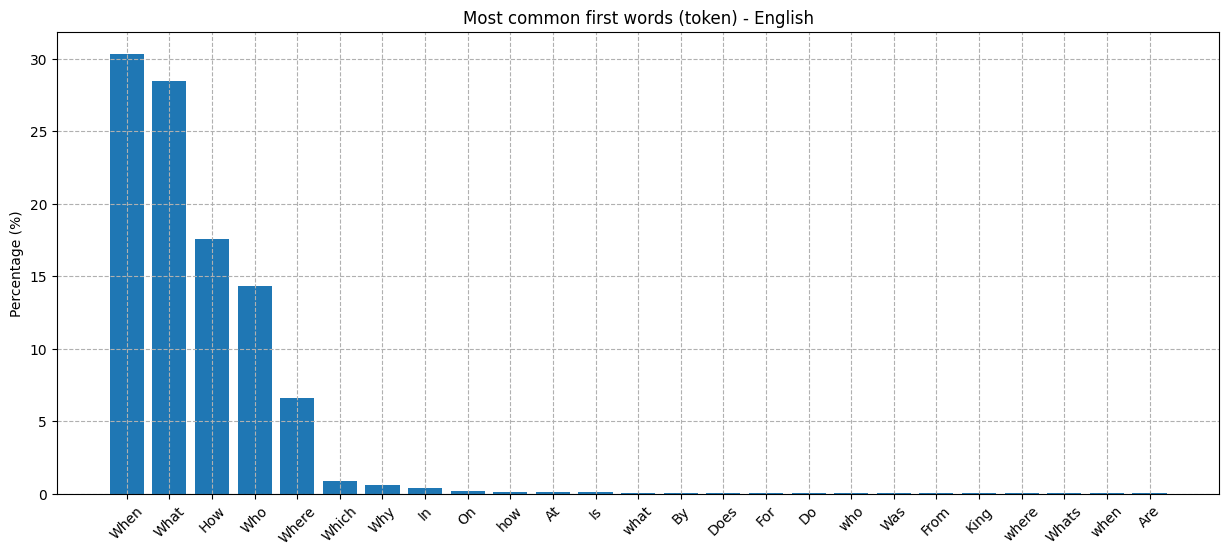

In [40]:
plot_most_common_words(firsts, "Most common first words (token) - English", top=25)

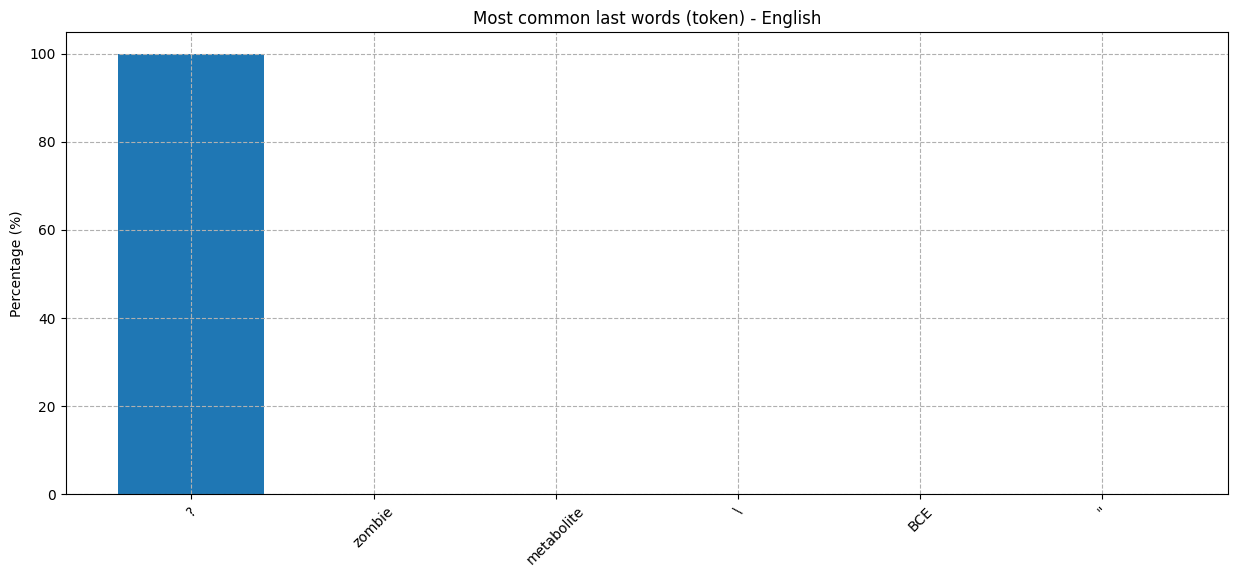

In [41]:
plot_most_common_words(lasts, "Most common last words (token) - English", top=25)

### Finnish trainset summary 

In [42]:
df_question = train_fi["question"]

firsts = get_firsts(df_question)
lasts = get_lasts(df_question)

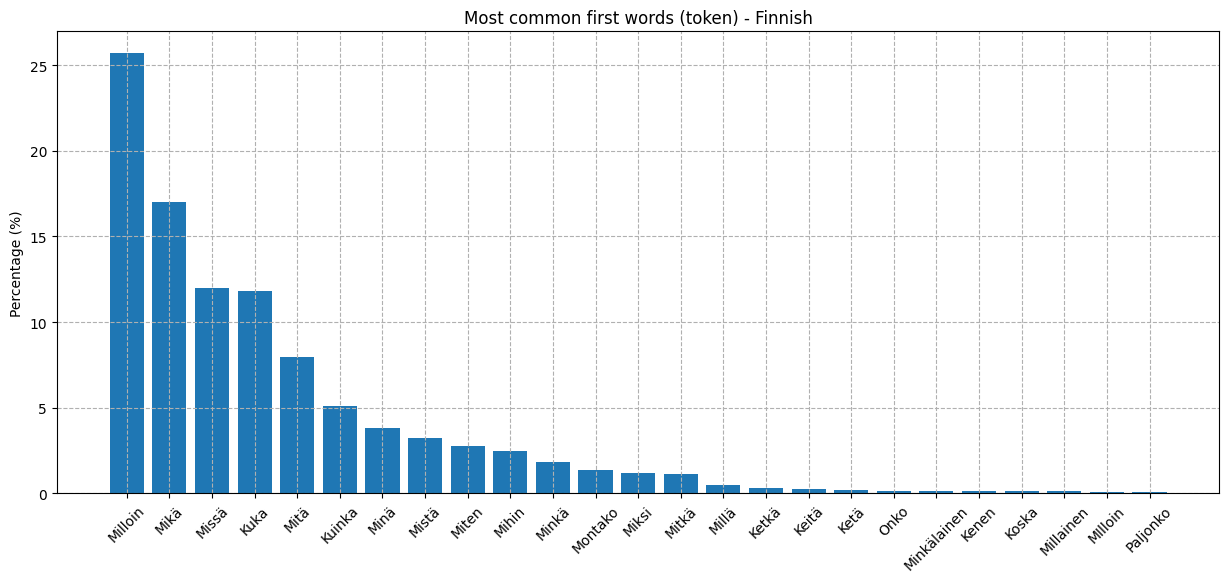

In [43]:
plot_most_common_words(firsts, "Most common first words (token) - Finnish", top=25)

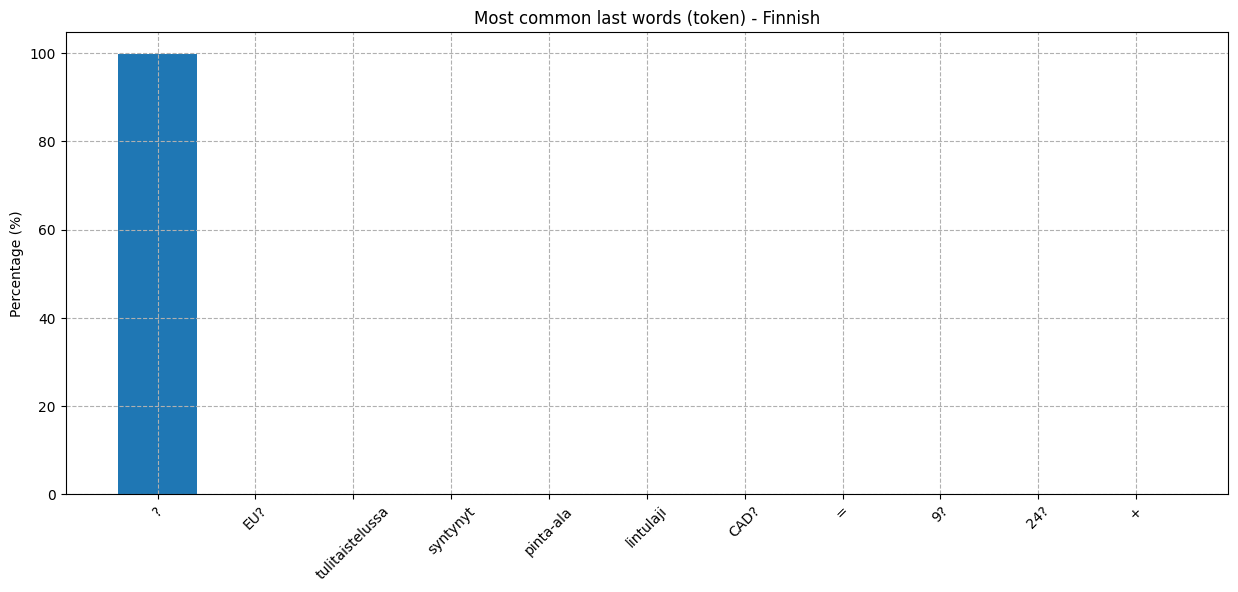

In [44]:
plot_most_common_words(lasts, "Most common last words (token) - Finnish", top=25)

### Japanese trainset summary 

Use a font which supports japanese characters.

In [45]:
import matplotlib.font_manager as fm
fprop = fm.FontProperties(fname='Osaka.ttc')

In [46]:
df_question = train_ja["question"]

firsts = get_firsts(df_question)
lasts = get_lasts(df_question)

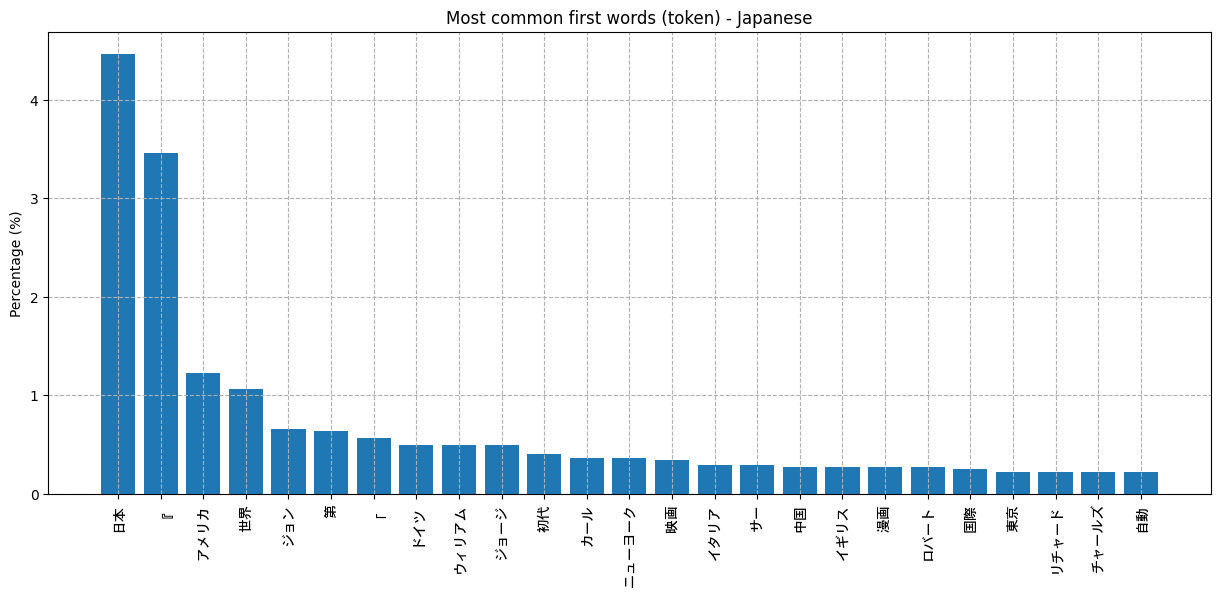

In [47]:
plot_most_common_words(firsts, "Most common first words (token) - Japanese", top=25, font_prop=fprop, rotation=90)

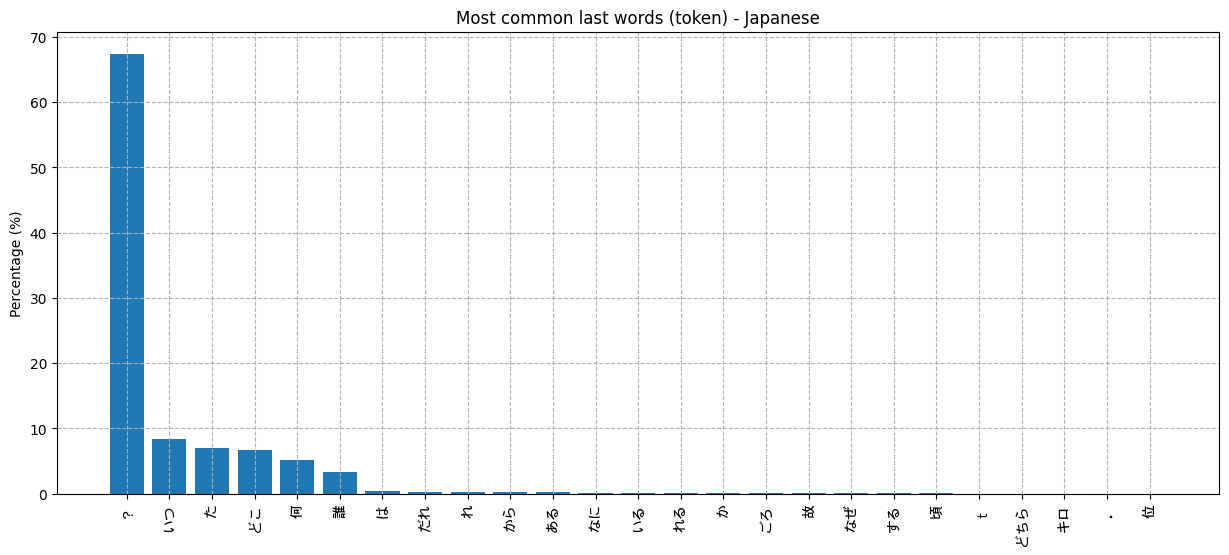

In [48]:
plot_most_common_words(lasts, "Most common last words (token) - Japanese", top=25, font_prop=fprop, rotation=90)